In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/names.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/anno_test.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/anno_train.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/04772.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/08033.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/03004.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/06551.jpg
/kaggle/input/stanford-car-dataset-images-in-224x

In [ ]:
trainpath = '/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/train'
testpath = '/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test'

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [14]:
batch_size = 32
img_size = (299, 299)
AUTOTUNE = tf.data.AUTOTUNE


# Xception Model

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="training", 
    seed=123,  
    label_mode='categorical',
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="validation", 
    seed=123,
    label_mode='categorical',
    shuffle=True
)

Found 8144 files belonging to 196 classes.
Using 6516 files for training.
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.


In [35]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    testpath,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 8041 files belonging to 196 classes.


In [36]:
test_dataset = (test_dataset
                .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
                .cache()
                .prefetch(buffer_size=AUTOTUNE))

In [18]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 196
Class names: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
train_dataset = (train_dataset
                 .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
                 .cache()
                 .shuffle(1000)
                 .prefetch(buffer_size=AUTOTUNE))

In [21]:
val_dataset = (val_dataset
               .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
               .cache()
               .prefetch(buffer_size=AUTOTUNE))

In [22]:
print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")

Train batches: 204
Validation batches: 51


In [23]:
X_batch, y_batch = next(train_batch)

print("Shape of X_batch:", X_batch.shape)
print("Shape of y_batch:", y_batch.shape)  
print("Example of a label (y_batch[0]):", y_batch[0])

Shape of X_batch: (32, 299, 299, 3)
Shape of y_batch: (32, 196)
Example of a label (y_batch[0]): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [6]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

test_batch = test_gen.flow_from_directory(
    directory=testpath,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 8041 images belonging to 196 classes.


In [24]:
from keras.optimizers import Adam
from keras.applications import Xception
from keras import layers, models
from keras.layers import Dense
from keras.models import Model

xception_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
xception_model.trainable = True  # Unfreeze the model

# Freeze specific layers if needed
for layer in xception_model.layers[:100]:  # Example: freeze first 100 layers
    layer.trainable = False

# Add custom top layers
model = models.Sequential([
    xception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(196, activation='softmax')
])



In [25]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # Fine-tuning requires a smaller learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 9,478,344 (36.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_xception_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')


history = model.fit(
    train_batch, 
    epochs=30, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 179s 775ms/step - accuracy: 0.0058 - loss: 5.3059
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 134s 625ms/step - accuracy: 0.0125 - loss: 5.2172
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 131s 613ms/step - accuracy: 0.0262 - loss: 5.1093
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 131s 613ms/step - accuracy: 0.0604 - loss: 4.9722
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 134s 625ms/step - accuracy: 0.0884 - loss: 4.8304
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 132s 616ms/step - accuracy: 0.1239 - loss: 4.6535
Epoch 7/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 131s 611ms/step - accuracy: 0.1541 - loss: 4.5039
Epoch 8/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 130s 606ms/step - accuracy: 0.2036 - loss: 4.3407
Epoch 9/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 134s 627ms/step - accuracy: 0.2293 - loss: 4.1904
Epoch 10/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 136s 636ms/step - accuracy: 0.2549 - loss: 4.0502
Epoch 11/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 136s 634ms/step - accuracy: 0.3005 - loss: 3.9110
Epoch 12

In [29]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 638ms/step - accuracy: 0.7474 - loss: 1.7550
Validation Loss: 1.7641817331314087
Validation Accuracy: 0.746314525604248


In [33]:
history = model.fit(
    train_batch, 
    validation_data=val_dataset,
    epochs=30, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 144s 675ms/step - accuracy: 0.7229 - loss: 1.8835 - val_accuracy: 0.7635 - val_loss: 1.6890
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 145s 677ms/step - accuracy: 0.7268 - loss: 1.8115 - val_accuracy: 0.7740 - val_loss: 1.6192
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 145s 679ms/step - accuracy: 0.7395 - loss: 1.7521 - val_accuracy: 0.7813 - val_loss: 1.5535
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 144s 675ms/step - accuracy: 0.7512 - loss: 1.6702 - val_accuracy: 0.7924 - val_loss: 1.4918
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 144s 672ms/step - accuracy: 0.7675 - loss: 1.6027 - val_accuracy: 0.7967 - val_loss: 1.4338
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 145s 678ms/step - accuracy: 0.7718 - loss: 1.5594 - val_accuracy: 0.8084 - val_loss: 1.3876
Epoch 7/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 145s 678ms/step - accuracy: 0.7853 - loss: 1.5092 - val_accuracy: 0.8108 - val_loss: 1.3261
Epoch 8/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 145s 679ms/step - accuracy: 0.7940 -

In [37]:
model.load_weights('/kaggle/working/best_xception_model.keras')


In [38]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.7874 - loss: 0.9691
Test Accuracy: 78.40%


In [39]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()


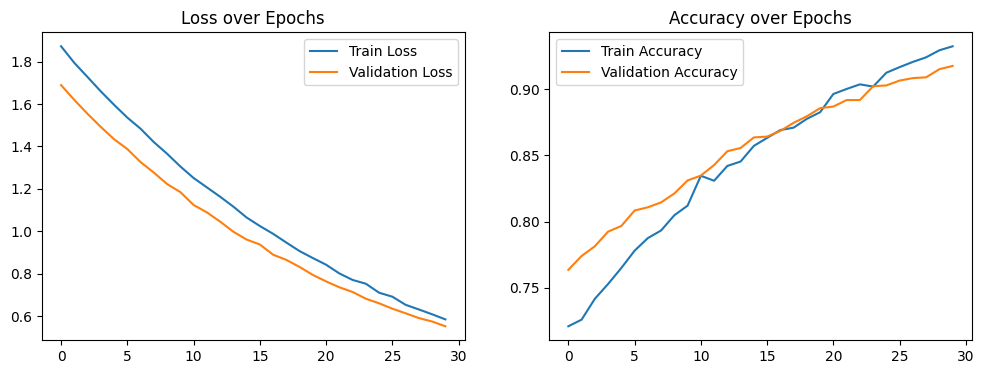

In [40]:
plot_history(history)

In [42]:
import numpy as np
Y_pred = model.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy()) 

y_true_one_hot = np.array(y_true)


252/252 ━━━━━━━━━━━━━━━━━━━━ 62s 241ms/step


In [43]:
if len(y_true_one_hot.shape) > 1 and y_true_one_hot.shape[1] > 1:
    y_true = np.argmax(y_true_one_hot, axis=1)


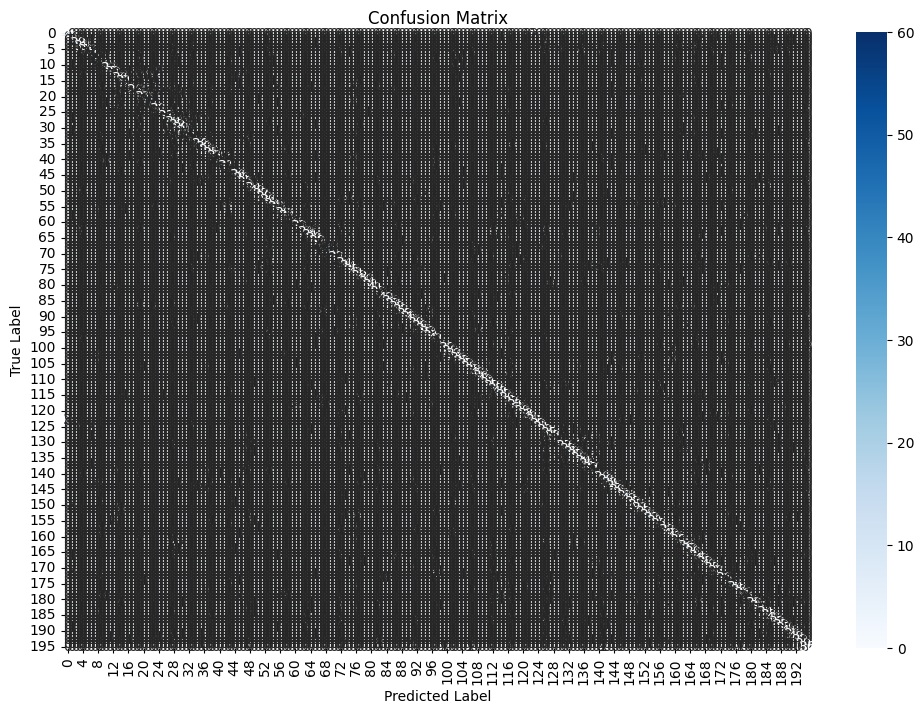

In [46]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [47]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
                                                         precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.93      0.95      0.94        44
                             Acura Integra Type R 2001       0.80      0.91      0.85        44
                                   Acura RL Sedan 2012       0.85      0.53      0.65        32
                                   Acura TL Sedan 2012       0.81      0.91      0.86        43
                                  Acura TL Type-S 2008       0.82      0.79      0.80        42
                                  Acura TSX Sedan 2012       0.88      0.72      0.79        40
                              Acura ZDX Hatchback 2012       0.75      0.62      0.68        39
              Aston Martin V8 Vantage Convertible 2012       0.50      0.53      0.52        45
                    Aston Martin V8 Vantage Coupe 2012       0.59      0.56      0.57        41
               

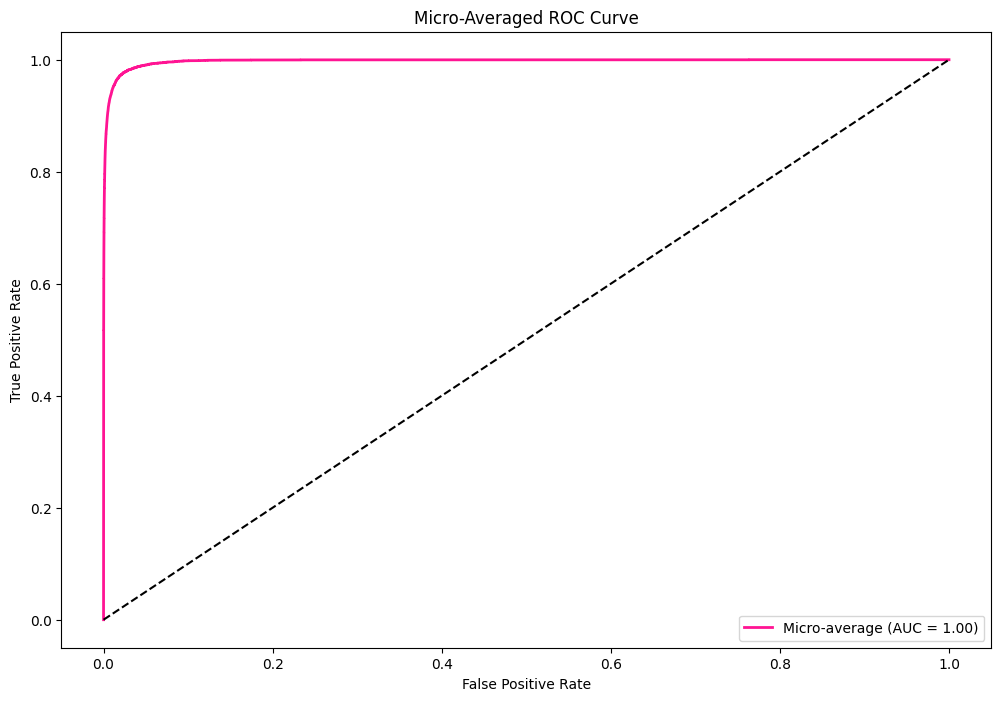

In [48]:
fpr = {}
tpr = {}
roc_auc = {}

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve')
plt.legend()
plt.show()
